# Simple Neural Network

In [1]:
import numpy as np
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2

## Problem description

Given a dataset that contains cat and non-cat images, you need to build a simple image recognition algorithm that can classify pictures as a cat or non-cat.

## Data preprocessing

In [2]:
# Loading dataset
train_set_x, train_set_y, test_set_x, test_set_y, classes = load_catvnoncat_dataset()

Info y = [1], it is a cat.


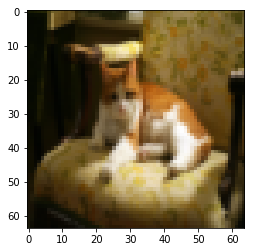

In [3]:
# Show a sample image
index = 7
plt.imshow(train_set_x[index])
print("Info y = {}, it is a {}."\
      .format(train_set_y[:, index], classes[np.squeeze(train_set_y[:, index])].decode("utf-8")))

In [4]:
num_train = train_set_x.shape[0]
num_test = test_set_x.shape[0]
num_px = train_set_x.shape[1]

print("Number of training samples: {}".format(num_train))
print("Number of test sample: {}".format(num_test))
print("Number of pixel (Height/Width): {}".format(num_px))
print("train_set_x.shape: {}".format(train_set_x.shape))
print("train_set_y.shape: {}".format(train_set_y.shape))
print("test_set_x.shape: {}".format(test_set_x.shape))
print("test_set_y.shape: {}".format(test_set_y.shape))

Number of training samples: 209
Number of test sample: 50
Number of pixel (Height/Width): 64
train_set_x.shape: (209, 64, 64, 3)
train_set_y.shape: (1, 209)
test_set_x.shape: (50, 64, 64, 3)
test_set_y.shape: (1, 50)


For convernience machine leanring:
* Flatting the training and test dataset shape form (m, height, width, channel) to (height * width * channel, m).
* Center and standardize dataset, substract the mean of the whole numpy array form each sample.

In [5]:
# Falt
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0], -1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0], -1).T

print("train_set_x_flatten.shape: {}".format(train_set_x_flatten.shape))
print("train_set_y.shape: {}".format(train_set_y.shape))
print("test_set_x_flatten.shape: {}".format(test_set_x_flatten.shape))
print("test_set_y.shape: {}".format(test_set_y.shape))

# Standardize
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

train_set_x_flatten.shape: (12288, 209)
train_set_y.shape: (1, 209)
test_set_x_flatten.shape: (12288, 50)
test_set_y.shape: (1, 50)


## Build Logistic Regression model

Logistic regression is a simple Neural Network, for one sample $ x^{(i)} $ :

$ z^{(i)} = w^T x^{(i)} + b $

$ \hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)}) $

$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)}) $

The cost function is:

$  J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)}) $

<b>Main steps:</b>

1. Initialize the parameters of the model.
2. Learn the parameters for minimizing the cost.
    * Forward propagation (calculate loss)
    * Backward propagation (calculate gradient)
    * Gradient descent (update paramenters)
3. User the learned parametner to predict on the test dataset.
4. Analyse the result.

### Initialize the parameters

Initialize the weight vector size and as a vector of zeros.

In [6]:
def initialize_paramenter(dim):
    """
    Arguments:
    dim - size of the weights
    
    Returns:
    W - initialized weight vecotr that shape is (dim, 1)
    b - initialized bias
    """
    W = np.zeros((dim, 1))
    b = 0
    return W, b

### Forward and Backward propagation

Forward propagation

* Input train data: $ X $
* Compute the preidction: $ \hat{Y} = sigmoid(W^T X + b) = (a^{(0)}, a^{(1)}, a^{(2)}, ..., a^{(m)}) $
* Compute the cost: $ J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}) $

Backward propagation

* Comput gradient of loss weights (dW): $ \frac{\partial{J}}{\partial{w}} = \frac{1}{m}X (\hat{Y}-Y)^T $
* Comput gradient of loss bias (db): $ \frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m (a^{(i)}-y^{(i)}) $ 

In [7]:
def propagate(W, b, X, Y):
    """
    Argumanets:
    W - weights, shape (D, 1)
    b - bias
    X - training data samples, shape (D ,M)
    Y - training data labels, shape (1, M)
    
    Returns:
    cost - negative cost for logistic regression
    grads - dictionary containing the gradient of loss weights and bias
    """
    m = X.shape[1]
    
    # Forward
    Y_hat = sigmoid(np.dot(W.T, X) + b) # shape (1, M)
    cost = -np.sum((Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))) / m
    
    # Backward
    dW = np.dot(X, (Y_hat - Y).T) / m # shape (D, 1)
    db = np.sum(Y_hat - Y) / m
    cost = np.squeeze(cost)
    
    grads = {"dW": dW, "db": db}
    return grads, cost

### Optimization

Using gradient desent to update paramenters.

$ \theta = \theta - \alpha \text{ } d\theta $, where $ \theta $ is parameters (weights and bias), $ \alpha $ is learning rate.

In [8]:
def optimize(W, b, X, Y, num_iterations, learning_rate, verbose=False):
    """
    Arguments:
    W - weights, shape (D, 1)
    b - biase
    X - training data samples, shape (D ,M)
    Y - training data labels, shape (1, M)    
    num_iterations - number of the optimization loop
    learning_rate - gradient desent updates step
    verbose - print the loss log
    
    Returns:
    params - dictionary containing the wieghts and bias
    grads - dictionary containing the gradient of loss weights and bias
    costs - list of all the costs
    """
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(W, b, X, Y)
        
        dW = grads["dW"]
        db = grads["db"]
        
        # update weights and bias
        W = W - learning_rate * dW
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if verbose and i % 100 == 0:
            print("Iteration[{}] - cost: {}".format(i, cost))
        
    params = {"W": W, "b": b}
    grads = {"dW": dW, "db": db}
    return params, grads, costs

### Prediction

Calculate $ \hat{Y} = sigmoid(W^T X + b) $

In [9]:
def predict(W, b, X):
    """
    Arguments:
    W - weights, shape (D, 1)
    b - biase
    X - test data samples, shape (D ,M)
    
    Returns:
    predicted_Y - all predictions for the test samples in X
    """
    
    m = X.shape[1]
    predicted_Y = np.zeros((1, m))
        
    Y_hat = sigmoid(np.dot(W.T, X) + b)
    
    for i in range(Y_hat.shape[1]):
        if Y_hat[0, i] <= 0.5:
            predicted_Y[0, i] = 0
        else:
            predicted_Y[0, i] = 1
    
    return predicted_Y

### Combin all functions into a model

In [10]:
def print_accuracy(set_type, Y, predicted_Y):
        print("{} accuracy: {}".format(set_type, 100 - np.mean(np.abs(predicted_Y -Y)) * 100))      

In [11]:
def run_model(train_X, train_Y, test_X, test_Y, num_iterations=1000, learning_rate=0.3, verbose=False):
    W, b = initialize_paramenter(train_X.shape[0])
    
    params, grads, costs = optimize(W, b, train_X, train_Y, num_iterations, learning_rate, verbose)
    
    W = params["W"]
    b = params["b"]

    predicted_train_Y = predict(W, b, train_X)
    predicted_test_Y = predict(W, b, test_X)
    
    print_accuracy("Train", train_Y, predicted_train_Y)
    print_accuracy("Test", test_Y, predicted_test_Y)
    
    model = {
        "costs": costs,
        "predicted_train_Y": predicted_train_Y,
        "predicted_test_Y": predicted_test_Y,
        "W": W,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations
    }
    return model

In [12]:
LR_model = run_model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005)

Train accuracy: 99.04306220095694
Test accuracy: 70.0


Y = 1, Predicted Y = cat


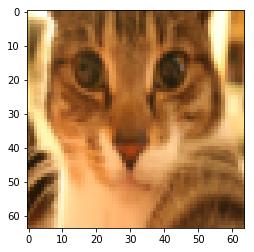

In [14]:
index = 3
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print("Y = {}, Predicted Y = {}".format(test_set_y[0, index], classes[int(LR_model["predicted_test_Y"][0, index])].decode("utf-8")))

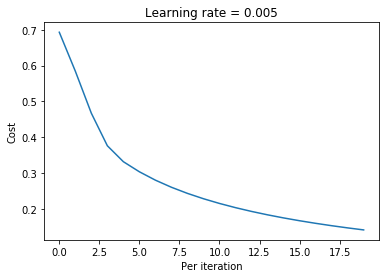

In [15]:
costs = np.squeeze(LR_model["costs"])
plt.title("Learning rate = {}".format(LR_model["learning_rate"]))
plt.ylabel("Cost")
plt.xlabel("Per iteration")
plt.plot(costs)
plt.show()

In [16]:
base_learning_rates = [0.3, 0.1]
decay_rates = [1., 0.1, 0.01]

models = {}
for blr in base_learning_rates:
    for decay in decay_rates:
        lr = blr * decay
        print("Learning rate = {}".format(lr))
        models[str(lr)] = run_model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=lr)
        print("---------------------------------------------")

Learning rate = 0.3


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply


Train accuracy: 100.0
Test accuracy: 74.0
---------------------------------------------
Learning rate = 0.03
Train accuracy: 100.0
Test accuracy: 68.0
---------------------------------------------
Learning rate = 0.003
Train accuracy: 97.12918660287082
Test accuracy: 70.0
---------------------------------------------
Learning rate = 0.1
Train accuracy: 100.0
Test accuracy: 66.0
---------------------------------------------
Learning rate = 0.010000000000000002
Train accuracy: 99.52153110047847
Test accuracy: 70.0
---------------------------------------------
Learning rate = 0.001
Train accuracy: 91.38755980861244
Test accuracy: 68.0
---------------------------------------------


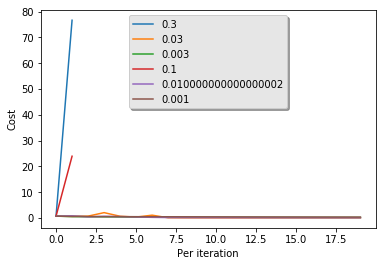

In [17]:
for blr in base_learning_rates:
    for decay in decay_rates:
        lr = blr * decay
        plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))
        
plt.ylabel("Cost")
plt.xlabel("Per iteration")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Build one hidden layer neural network

$ z^{[1][i]} = W^{[1]} x^{(i)} + b^{[1](i)} $

$ a^{[1](i)} = tanh(z^{[1](i)}) $

$ z^{[2][i]} = W^{[2} a^{[1](i)} + b^{[2](i)} $

$ \hat{y}^{(i)} = a^{[2](i)} = \sigma(z^{[2](i)})$

$ y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases} $

### Define the neural network structure and Initialize the parameters

In [21]:
def layer_sizes(X, Y, h=4):
    """
    Arguments:
    X - Input that shape is (input size, number of samples)
    Y - Output that shape is (output size, number of samples)
    
    Returns:
    n_x - the size of the input layer
    n_h - the size of the hidden layer
    n_y - the size of the output layer
    """
    n_x = X.shape[0] # Size of input layer
    n_h = h # Size of hidden layer
    n_y = Y.shape[0] # Size of output layer
    return (n_x, n_h, n_y)

In [20]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Arguments:
    n_x - Input size
    n_h - Hidden size
    n_y - Output size
    
    Returns:
    params - containing:
            W1 - first layer weights that shape is (n_h, n_x)
            b1 - first layer bias that shape is (n_h, 1)
            W2 - second layer weights that shape is (n_y, n_h)
            b2 - second layer bias that shape is (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params

### Forward propagation

$ z^{[1]} = W^{[1]} X + b^{[1]} $

$ a^{[1]} = tanh(z^{[1]}) $

$ z^{[2]} = W^{[2} a^{[1]} + b^{[2]} $

$ a^{[2]} = \sigma(z^{[2]})$

In [113]:
def forward_propagation(X, params):
    """
    Arguments
    X - input data that shape is (n_x, m)
    params - parameters containing output of initialize_parameters function
    
    Returns
    cache - a dictionary containing "Z1", "A1", "Z2", and "A2"
    """
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    return cache

### Cost function

$ J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} $

In [114]:
def compute_cost(A2, Y, params):
    """
    Arguments
    A2 - The sigmoid output of the second layer's activation that shape is (1, number of samples)
    Y - The ground truth that shape is (1, number of samples)
    params - The parameters containing W1, b1, W2, b2
    
    Returns
    cost - Cross-entropy
    """
    m = Y.shape[1]
    log_probs = (np.log(A2) * Y) + ((1 - Y) * (1 - A2))
    cost = -np.sum(log_probs) / float(m)
    cost = np.squeeze(cost)
    return cost

### Backward progagation

$ dz^{[2]} = a^{[2]} - y $

$ dW^{[2]} = \frac {1}{m} dz^{[2]} a^{[2]^{T}} $

$ db^{[2]} = \frac {1}{m} \sum dz^{[2]} $

$ dz^{[1]} = W^{[2]^{T}} dz^{[2]} *  {g^{[1]}}'(z^{[1]}) $

$ dW^{[1]} = \frac {1}{m} dz^{[1]} x^{T} $

$ db^{[1]} = \frac {1}{m} \sum dz^{[1]} $


<b>Note:</b> $ {g^{[1]}}'$ is `tanh` activation function's derivative.

In [115]:
def backward_progagation(params, cache, X, Y):
    
    m = X.shape[1]
    
    W1 = params["W1"]
    W2 = params["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1. / m) * np.dot(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1. / m) * np.dot(dZ1, X.T)
    db1 = (1.0 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
    return grads

### Update parameters

In [116]:
def update_parameters(params, grads, learning_rate):
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    params = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }
    return params

### Predection

In [117]:
def predict(params, X):
    cache = forward_propagation(X, params)
    predicted_Y = np.where(cache["A2"] >= 0.5, 1, 0)
    return predicted_Y

### Combin sub-functions into a neural network model

In [121]:
def nn_model(train_X, train_Y, n_h, test_X, test_Y, num_iterations=200, learning_rate=0.005, verbose=False):
    
    n_x, _, n_y = layer_sizes(train_X, train_Y, n_h)
        
    params = initialize_parameters(n_x, n_h, n_y)
    # W1 = params["W1"]
    # b1 = params["b1"]
    # W2 = params["W2"]
    # b2 = params["b2"]
    costs = []
    for i in range(num_iterations):
        cache = forward_propagation(train_X, params)
        cost = compute_cost(cache["A2"], train_Y, params)
        grads = backward_progagation(params, cache, train_X, train_Y)
        
        params = update_parameters(params, grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
        
        if verbose and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            
    predicted_train_Y = predict(params, train_X)
    print_accuracy("Train", train_Y, predicted_train_Y)
    predicted_test_Y = predict(params, test_X)
    print_accuracy("Test", test_Y, predicted_test_Y)
    
    model = {
        "params": params,
        "costs": costs,
        "grads": grads,
        "learning_rate": learning_rate,
        "predicted_train_Y": predicted_train_Y,
        "predicted_test_Y": predicted_test_Y,
        "num_iterations": num_iterations
    }
    return model

In [124]:
NN_model = nn_model(train_set_x, train_set_y, 40, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005)

Train accuracy: 98.56459330143541
Test accuracy: 72.0


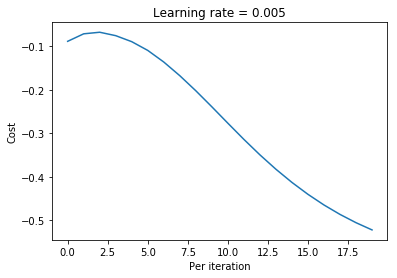

In [123]:
costs = np.squeeze(NN_model["costs"])
plt.title("Learning rate = {}".format(NN_model["learning_rate"]))
plt.ylabel("Cost")
plt.xlabel("Per iteration")
plt.plot(costs)
plt.show()